# 3. A Tour of Machine Learning Classifiers Using Scikit-Learn

## Choosing a classification algorithm

No single classifier works best across al possible scenarios (*NFL Theorem*). In practice, it is always recommended that you compare the performance of al least a handful of different learning algorithms to select the best model for the particular problem.

## First steps with scikit-learn - training a perceptron

In [1]:
from sklearn import datasets
import numpy as np

iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target

In [2]:
print("Class labels:", np.unique(y))

Class labels: [0 1 2]


In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

By default `train_test_split` shuffles the data before splitting

In [4]:
print("Labels counts in y:", np.bincount(y))
print("Labels count in train:", np.bincount(y_train))
print("Labels count in test:", np.bincount(y_test))

Labels counts in y: [50 50 50]
Labels count in train: [35 35 35]
Labels count in test: [15 15 15]


In [5]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

Using the `fit` method, `StandardScaler` estimated the parameters, $\mu$ (sample mean) and $\sigma$ (standard deviation), for each feature dimension from training data. By calling `transform` method, we then standardized data using those estimated parameters, $\mu$ and $\sigma$.

Most algorithms in sklearn already support multiclass classification by default via the **one-versus-rest**(**OvR**) method.

In [6]:
from sklearn.linear_model import Perceptron

ppn = Perceptron(eta0=0.1, random_state=42)
ppn.fit(X_train_std, y_train)

Perceptron(eta0=0.1, random_state=42)

In [7]:
y_pred = ppn.predict(X_test_std)
print("Misclassified examples: %d" % (y_test != y_pred).sum())

Misclassified examples: 7


In [8]:
from sklearn.metrics import accuracy_score

print("Accuracy: %.3f" % accuracy_score(y_test, y_pred))

Accuracy: 0.844


In [9]:
print("Accuracy: %.3f" % ppn.score(X_test_std, y_test))

Accuracy: 0.844


**Overfitting:** The model captures patterns in the training data well but fails to generalize well to unseen data

In [10]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt


def plot_decision_regions(
    X, y, classifier, test_idx=None, resolution=0.02, xlabel="", ylabel="", title=""
):
    # setup marker generator and color map
    markers = ("o", "s", "^", "v", "<")
    colors = ("red", "blue", "lightgreen", "gray", "cyan")
    cmap = ListedColormap(colors[: len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(
        np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution)
    )
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(
            x=X[y == cl, 0],
            y=X[y == cl, 1],
            alpha=0.8,
            c=colors[idx],
            marker=markers[idx],
            label=f"Class {cl}",
            edgecolors="black",
        )

    # highlight test examples
    if test_idx:
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(
            X_test[:, 0],
            X_test[:, 1],
            c="none",
            edgecolors="black",
            marker="o",
            alpha=1.0,
            linewidths=1,
            s=100,
            label="Test set",
        )

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

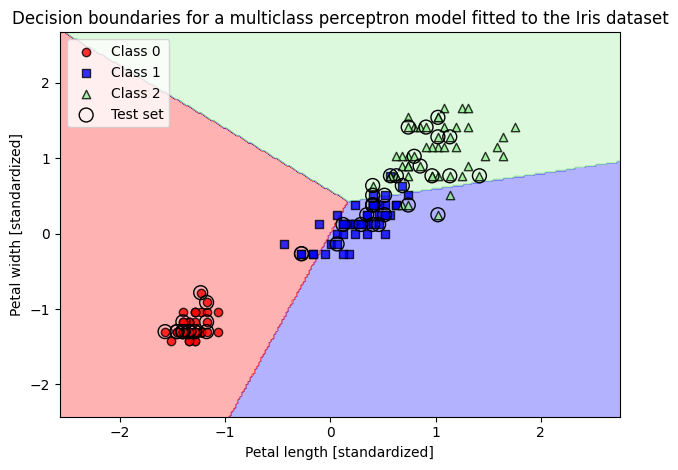

In [11]:
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(
    X=X_combined_std,
    y=y_combined,
    classifier=ppn,
    test_idx=range(105, 150),
    xlabel="Petal length [standardized]",
    ylabel="Petal width [standardized]",
    title="Decision boundaries for a multiclass perceptron model fitted to the Iris dataset",
)

As we can see in the resulting plot, the three flower classes can't be perfectly separated by linear decision boundary. Perceptron algorithm never converges on datasets that aren't perfectly linear separable, which is why the use of perceptron algorithm is typically not recommended in practice.

## Logistic regression and conditional probabilities